In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

In [2]:
%%time
############################
######## LIBRAIRIES ########
############################
from sklearn.linear_model import LinearRegression
from colorama import Fore, Back, Style
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johasen
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import sklearn.preprocessing
from statsmodels.tsa.stattools import adfuller
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import datetime as dt
import numpy as np
import fxcmpy
print('version fxcmpy :',fxcmpy.__version__)
%matplotlib inline
plt.style.use('seaborn')


version fxcmpy : 1.2.6
CPU times: user 1.39 s, sys: 393 ms, total: 1.78 s
Wall time: 2.36 s


In [3]:
##############################################
######## INITIALISATION DES VARIABLES ########
##############################################

TOKEN = 'xxx'
server = 'demo'
user_id = 'xxx'
compte = 'xxx'
password = 'xxx'
# minutes: 'm1' , 'm5' , 'm15' , 'm30' 
# hours: 'H1' , 'H2', 'H3', 'H4', 'H6' 'H8'
# one day: 'D1'
# one week: 'W1'
# one month: 'M1'
period = 'm5'
number = 5000 # Nombre de periodes pour l'historique
invers = 'non'
diloug = 2016  # 7 jours pour le training

break_it = 0
stop = 0
full_stop = 1

sens = 'INIT'

os = 0
ol = 0
cs = 0
cl = 0
buy1 = 0
buy2 = 0
buy3 = 0
sell1 = 0
sell2 = 0
sell3 = 0
nbposs = 0
nbposl = 0
nbpos = 0
nbre_trade = 0
nbre_trade_long = 0
nbre_trade_short = 0
pnll = 0
pnls = 0
eol = 0
auol = 0
chol = 0
gbol = 0
jpol = 0
eos = 0
auos = 0
chos = 0
gbos = 0
jpos = 0

dyn_net_pnl = 0
amplitude = 0

mise = 1200
mise = mise/10

CSTE = []
DYNS = []

In [4]:
############################
######## FONCTIONS ########
###########################

def conX():
    con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error',server=server)
    if con.is_connected() == True:
        print(Fore.GREEN+'Connexion établie'+Style.RESET_ALL)
        print('Compte utilisé : ',con.get_account_ids())
    else:
        print(Fore.RED+'Connexion non établie'+Style.RESET_ALL)
    return(con)

def mid_conX():
    con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error',server=server)
    return(con)


def deconX():
    con.close()
    if con.is_connected() == True:
        print(Fore.GREEN+'Connexion non intérrompue'+Style.RESET_ALL)
        print('Compte utilisé : ',con.get_account_ids())
    else:
        print(Fore.RED+'Connexion intérrompue'+Style.RESET_ALL)
    return()


def remove_index():
    for ind in INDEX:
        if ind not in base_audusd.index :
            INDEX.remove(ind)
    for ind in INDEX:
        if ind not in base_chfusd.index :
            INDEX.remove(ind)
    for ind in INDEX:
        if ind not in base_eurusd.index :
            INDEX.remove(ind)
    for ind in INDEX:
        if ind not in base_gbpusd.index :
            INDEX.remove(ind)
    for ind in INDEX:
        if ind not in base_jpyusd.index:
            INDEX.remove(ind)
    return(INDEX)

def clean_index(df):
    I = []
    for i in range(0,len(df)):
        if df.index[i] not in INDEX:
            I.append(i)
    df = df.drop(df.index[I])
    
    return(df)

def scrap_hist(ticker,invers = 'non'):
    #start = dt.datetime(2020, 4, 12)
    #stop = dt.datetime(2020, 4, 14)
    data = con.get_candles(ticker,period=period,number=number)
    #data = con.get_candles(ticker,period=period,start=start,stop=stop)
    df = pd.DataFrame(index=data.index)
    #df.index = data.index
    df['Open'] = (data['bidopen']+data['askopen'])/2
    df['High'] = (data['bidhigh']+data['askhigh'])/2
    df['Low'] = (data['bidlow']+data['asklow'])/2
    df['Close'] = (data['bidclose']+data['askclose'])/2
    if invers == 'oui':
        df['Open'] = 1 / df['Open']
        df['High'] = 1 / df['High']
        df['Low'] = 1 / df['Low']
        df['Close'] = 1 / df['Close']

    return(df)

def isname(pair):
    global name
    if pair.equals(eurusd):
        name = 'EUR/USD'
    elif pair.equals(audusd):
        name = 'AUD/USD'
    elif pair.equals(chfusd):
        name = 'CHF/USD'
    elif pair.equals(gbpusd):
        name = 'GBP/USD'
    elif pair.equals(jpyusd):
        name = 'JPY/USD'
    
    return(name)

def revname(name):
    if name == 'EUR/USD':
        pair = eurusd
    elif name == 'AUD/USD':
        pair = audusd
    elif name == 'CHF/USD':
        pair = chfusd
    elif name == 'GBP/USD':
        pair = gbpusd
    elif name == 'JPY/USD':
        pair = jpyusd
        
    return(pair)

def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()

    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    if p_value <= 0.05:
        stop = 0
    else:
        stop = 1
    return(stop)

def skewness(df):
    if skew < -0.1 or skew > 0.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def kurtos(df):
    if kurtosis > -3.1 or kurtosis < 3.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor(df):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor_diff(diff):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        p = 1
    else:
        stop = 1
    return()

def test_stationarity(timeseries,lag):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

def test_adf(df):
    X = df['Close'].values
    result_adf = adfuller(X)
    
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        stop = 1
    else:
        stop = 0
        
    X = diff[1:].values
    result_adf = adfuller(X)
    
    if result_adf[1] >= 0.05 :
        stop = 1

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        stop = 1

    else:
        stop = 0
    return(stop)


def train(base_eurusd,base_audusd,base_chfusd,base_gbpusd,base_jpyusd,TIME_FRAME):
    global pair,eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,kmo_all,chi_square_value,p_value,ev,v,jh_results,v1,v2,skew,kurtosis,df,full_stop,residu,S,\
    coef,cste,break_it,debut,fin,split,step,mark

    now = time.localtime(time.time())
    print('\nHeure locale du début du train : ',time.strftime("%Y-%m-%d %H:%M:%S", now),'\n')
    
    for step in range(len(TIME_FRAME),diloug,-1):
        print(Fore.MAGENTA,'')
        print('Step : ',step, '|||| TIME_FRAME[step] <---> debut :',TIME_FRAME[step-diloug]) #,'TIME_FRAME[step+diloug - 576] : ',TIME_FRAME[step+diloug-576],\
        #'TIME_FRAME[step+diloug] <----> split', TIME_FRAME[step+diloug])
        print(Style.RESET_ALL,'')
        debut = TIME_FRAME[step-diloug-576] #suppression des 2 jours
        split = TIME_FRAME[step-576] #suppression des 2 jours
        fin = TIME_FRAME[-1]#step+diloug]

        eurusd = base_eurusd[(base_eurusd.index >= debut)&(base_eurusd.index <= split)]
        eurusd['Local time'] = eurusd.index
        eurusd.reset_index(drop=True, inplace=True)
        audusd = base_audusd[(base_audusd.index >= debut)&(base_audusd.index <= split)]
        audusd['Local time'] = audusd.index
        audusd.reset_index(drop=True, inplace=True)
        chfusd = base_chfusd[(base_chfusd.index >= debut)&(base_chfusd.index <= split)]
        chfusd['Local time'] = chfusd.index
        chfusd.reset_index(drop=True, inplace=True)
        gbpusd = base_gbpusd[(base_gbpusd.index >= debut)&(base_gbpusd.index <= split)]
        gbpusd['Local time'] = gbpusd.index
        gbpusd.reset_index(drop=True, inplace=True)
        jpyusd = base_jpyusd[(base_jpyusd.index >= debut)&(base_jpyusd.index <= split)]
        jpyusd['Local time'] = jpyusd.index
        jpyusd.reset_index(drop=True, inplace=True)


        PAIR = [eurusd,audusd,chfusd,gbpusd,jpyusd]

        for pair in PAIR:

            name = isname(pair)

            model = sm.OLS(pair['Close'],pair.index)
            results = model.fit()
            residuals = results.resid
            summary = results.summary()

            jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

            jarque_berra(pair)
            skewness(pair)
            kurtos(pair)
            autocor(pair)
        df = pd.DataFrame()
        for pair in PAIR:
            name = isname(pair)
            df[name] = list(pair['Close'])
        df.corr().style.background_gradient(cmap='coolwarm')

        INTEGRE = []
        for col in range(1,len(df.corr())):
            for ind in range(col):
                if df.corr().iloc[ind,col] > 0.5 and df.corr().iloc[ind,col] != 1:
                    INTEGRE.append((df.corr().index[ind],df.corr().columns[col]))


        INTEGRE  = list(set(INTEGRE))

        kmo_all,kmo_model=calculate_kmo(df)

        for loop,pair in enumerate(PAIR):
            name = isname(pair)
            if kmo_all[loop] >= 0.6:
                print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquat',Style.RESET_ALL)
            else:
                print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)
                #if name == 'EUR/USD':
                print('Problème sur la base principale. On procède à un saut incrémentiel')
                break_it = 1

        chi_square_value,p_value=calculate_bartlett_sphericity(df)
        if p_value < 0.05:
            stop = 0
        else:
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 311\n\n\n',Style.RESET_ALL)

        fa = FactorAnalyzer(rotation=None)
        fa.fit(df)

        ev, v = fa.get_eigenvalues()

        PRINCIPAL_COMPOSANT = []
        for loop,pair in enumerate(PAIR):
            name = isname(pair)
            if ev[loop] >= 1:
                PRINCIPAL_COMPOSANT.append((name,ev[loop]))

        jh_results = johasen(df,0,1)
        v1 = jh_results.evec[:, 0]
        v2 = jh_results.evec[:, 1]
        if jh_results.eig[0] <= 0.05:
            stop = 0
        else:
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 333\n\n\n',Style.RESET_ALL)
        
        X = df.iloc[:,1:]
        y = df.iloc[:,0]
        reg = LinearRegression().fit(X, y)
        score = reg.score(X, y) *100
        coef = reg.coef_
        cste = reg.intercept_
        CSTE.append(cste)

        if score > 70:
            stop = 0
            loop = -1
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 432\n\n\n',Style.RESET_ALL)

        elif score > 50:
            
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 448\n\n\n',Style.RESET_ALL)

        else:
            stop = 1
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 465\n\n\n',Style.RESET_ALL)
                        continue

        combo = coef[0] * df['AUD/USD'] + coef[1] * df['CHF/USD'] + coef[2] * df['GBP/USD'] + coef[3] * df['JPY/USD'] + cste

        ########
        ### RESIDUS
        ########
        residu = df['EUR/USD']-combo
        S = (residu - residu.mean())/residu.std()

        ####
        ## ANALYSE DES RESIDUS
        ###

        jarque_berra(residu)
        skewness(residu)
        kurtos(residu)
        residu_autocor = pd.DataFrame()
        residu_autocor['Close'] = residu.iloc[:]
        autocor(residu_autocor)

        model = sm.OLS(residu,residu.index)
        results = model.fit()
        residuals = results.resid
        summary = results.summary()
        name = 'Analyse des Résidus'
        jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

        dfoutput =  test_stationarity(residu,lag = 1)
        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
            stop = 0
        else:
            print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 501\n\n\n',Style.RESET_ALL)

        #######
        ### RETOUR A LA MOYENNE
        #######
        dfoutput =  test_stationarity(residu,lag = 0)

        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 0
        else:
            print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 516\n\n\n',Style.RESET_ALL)


        chi_square_value,p_value=calculate_bartlett_sphericity(df)
        if p_value < 0.05:
            #print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
            pass
        else:
            #print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )
            pass

        fa = FactorAnalyzer(rotation=None)
        fa.fit(df)

        ev, v = fa.get_eigenvalues()



        pca = PCA(n_components=2)
        pca.fit(df)

        x_pca = pca.transform(df)
        x_pca.shape


        for loop,pair in enumerate(PAIR):
            name = isname(pair)

        jh_results = johasen(df,0,1)

        v1 = jh_results.evec[:, 0]
        v2 = jh_results.evec[:, 1]

        if jh_results.eig[0] <= 0.05:
            #print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
            pass
        else:
            #print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)
            pass
        print('\nTEST DU FULL STOP - et stop à ',stop,' - ','\n')
        if stop == 0 and break_it != 1:
            print('\nFull Stop à 0\n')
            full_stop = 0
            print('Trader, trader, pour information, la constante vaut ',cste)
            print(Back.LIGHTBLUE_EX,Fore.YELLOW,' P E R I O D E    D E    T R A I N    T E R M I N E E ',Style.RESET_ALL)
            print('\n\n')
            break
        else:
            print('\nFull Stop à 1\n')
            full_stop = 1
            break_it = 0
    return(eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,split,step,S)

def dyns_close(): 
    global lim_s1,lim_s2,lim_s3,lim_l1,lim_l2,lim_l3,lim_cs,lim_cl,amplitude,dyn_S

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)
    print('\nDernière convergence atteinte le ',str(TIME_FRAME[step-diloug]),'\n')

    print('\n\nTAILLES DES POSITIONS :')
    try:
        print('EUR/USD : ', mise)
    except:
        print('EUR/USD => NON VALIDE')

    try:
        print('AUD/USD : ',coef[0] * mise)
    except:
        print('AUD/USD => NON VALIDE')
    try:
        print('CHF/USD : ',coef[1] * mise)
    except:
        print('CHF/USD => NON VALIDE')
    try:
        print('GBP/USD : ',coef[2] * mise)
    except:
        print('GBP/USD => NON VALIDE')
    try:
        print('JPY/USD : ',coef[3] * mise)
    except:
        print('JPY/USD => NON VALIDE')
    print('\n')

    print('Le Score max est : ',max(S),' et le Score min : ',min(S))

    mark = -1
   
    dyn_eurusd = scrap_hist(ticker='EUR/USD',invers = 'non')
    dyn_eurusd['Local time'] = dyn_eurusd.index
    dyn_eurusd.reset_index(drop=True, inplace=True)
    #dyn_eurusd = dyn_eurusd.iloc[-576:,:]
    dyn_audusd = scrap_hist(ticker='AUD/USD',invers = 'non')
    dyn_audusd['Local time'] = dyn_audusd.index
    dyn_audusd.reset_index(drop=True, inplace=True)
    #dyn_audusd = dyn_audusd.iloc[-576:,:]
    dyn_chfusd = scrap_hist(ticker='USD/CHF',invers= 'oui')
    dyn_chfusd['Local time'] = dyn_chfusd.index
    dyn_chfusd.reset_index(drop=True, inplace=True)
    #dyn_chfusd = dyn_chfusd.iloc[-576:,:]
    dyn_gbpusd = scrap_hist(ticker='GBP/USD',invers = 'non')
    dyn_gbpusd['Local time'] = dyn_gbpusd.index
    dyn_gbpusd.reset_index(drop=True, inplace=True)
    #dyn_gbpusd = dyn_gbpusd.iloc[-576:,:]
    dyn_jpyusd = scrap_hist(ticker='USD/JPY',invers= 'oui')
    dyn_jpyusd['Local time'] = dyn_jpyusd.index
    dyn_jpyusd.reset_index(drop=True, inplace=True)
    #dyn_jpyusd = dyn_jpyusd.iloc[-576:,:]


    df = pd.DataFrame(index=dyn_audusd['Local time'])
    df['EUR/USD'] = list(dyn_eurusd['Close'])
    df['AUD/USD'] = list(dyn_audusd['Close'])
    df['CHF/USD'] = list(dyn_chfusd['Close'])
    df['GBP/USD'] = list(dyn_gbpusd['Close'])
    df['JPY/USD'] = list(dyn_jpyusd['Close'])

    dynamic_df = df[df.index <= dyn_audusd.iloc[mark]['Local time']]
    print(Fore.MAGENTA,'')
    print('Indice : ',mark,dyn_audusd.iloc[mark]['Local time'])
    print('(Heure correspondanr à la dernière bougie récupérée)')
    print(Style.RESET_ALL,'')
    print(Back.RED,Fore.BLACK,' A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S',Style.RESET_ALL,'\n')

    dynamic_combo = coef[0] * dynamic_df['AUD/USD'] + coef[1] * dynamic_df['CHF/USD'] + coef[2] * dynamic_df['GBP/USD'] \
    + coef[3] * dynamic_df['JPY/USD'] + cste

    dynamic_residu = dynamic_df['EUR/USD'] - dynamic_combo
    dyn_S = (dynamic_residu - dynamic_residu.mean())/dynamic_residu.std()
    DYNS = []
    DYNS.append(dyn_S.iloc[-2016:])
    dyn_S = dyn_S[-1]
    
    amplitude = round(max(DYNS[-1]),4) - round(min(DYNS[-1]),4)
    print("L'amplitude détectée est de ",amplitude)

    lim_s1 = np.array(DYNS).mean()+1*np.array(DYNS).std() #np.array(DYNS).mean()+1*np.array(DYNS).std()
    lim_s2 = np.array(DYNS).mean()+1.5*np.array(DYNS).std()
    lim_s3 = np.array(DYNS).mean()+2*np.array(DYNS).std()
    print('Limite short 1',lim_s1,'Limite short 2',lim_s2,'Limite short 3',lim_s3)
    lim_l1 = np.array(DYNS).mean()-1*np.array(DYNS).std()
    lim_l2 = np.array(DYNS).mean()-1.5*np.array(DYNS).std()
    lim_l3 = np.array(DYNS).mean()-2*np.array(DYNS).std()
    print('Limite long 1',lim_l1,'Limite long 2',lim_l2,'Limite long 3',lim_l3)
    lim_cs = np.array(DYNS).mean()-0*np.array(DYNS).std()
    print('Limite close short',lim_cs)
    lim_cl = np.array(DYNS).mean()+0*np.array(DYNS).std()
    print('Limite close long',lim_cl)

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)
    print('Pour mémoire le spread (résidu) dynamique est de :',dynamic_residu[-1])

    plt.ion() 
    DYNS[-1].plot(figsize=(22,5))
    plt.axhline(y=lim_s1,c='olivedrab',alpha=0.8,linestyle='--',label='Open Short signal 1')
    plt.axhline(y=lim_s2,c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal 2')
    plt.axhline(y=lim_s3,c='olivedrab',alpha=0.2,linestyle='--',label='Open Short signal 3')
    plt.axhline(y=lim_cl,c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
    plt.axhline(y=lim_cs,c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
    plt.axhline(y=lim_l1,c='green',alpha=0.8,linestyle='--',label='Open Buy signal 1')
    plt.axhline(y=lim_l2,c='green',alpha=0.4,linestyle='--',label='Open Buy signal 2')
    plt.axhline(y=lim_l3,c='green',alpha=0.2,linestyle='--',label='Open Buy signal 3')
    plt.axhline(y=(lim_cl+lim_cs)/2,c='magenta',alpha=0.4,linestyle=':',label='Zéro')
    plt.legend()
    plt.title('Plot Signaux Achat / Vente sur le Score')
    plt.pause(0.05)

    return()

def dyns(): 
    global dyn_S

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)
    print('\nDernière convergence atteinte le ',str(TIME_FRAME[step-diloug]),'\n')

    print('\n\nTAILLES DES POSITIONS :')
    try:
        print('EUR/USD : ', mise)
    except:
        print('EUR/USD => NON VALIDE')

    try:
        print('AUD/USD : ',coef[0] * mise)
    except:
        print('AUD/USD => NON VALIDE')
    try:
        print('CHF/USD : ',coef[1] * mise)
    except:
        print('CHF/USD => NON VALIDE')
    try:
        print('GBP/USD : ',coef[2] * mise)
    except:
        print('GBP/USD => NON VALIDE')
    try:
        print('JPY/USD : ',coef[3] * mise)
    except:
        print('JPY/USD => NON VALIDE')
    print('\n')

    print('Le Score max est : ',max(S),' et le Score min : ',min(S))

    mark = -1
   
    dyn_eurusd = scrap_hist(ticker='EUR/USD',invers = 'non')
    dyn_eurusd['Local time'] = dyn_eurusd.index
    dyn_eurusd.reset_index(drop=True, inplace=True)
    #dyn_eurusd = dyn_eurusd.iloc[-576:,:]
    dyn_audusd = scrap_hist(ticker='AUD/USD',invers = 'non')
    dyn_audusd['Local time'] = dyn_audusd.index
    dyn_audusd.reset_index(drop=True, inplace=True)
    #dyn_audusd = dyn_audusd.iloc[-576:,:]
    dyn_chfusd = scrap_hist(ticker='USD/CHF',invers= 'oui')
    dyn_chfusd['Local time'] = dyn_chfusd.index
    dyn_chfusd.reset_index(drop=True, inplace=True)
    #dyn_chfusd = dyn_chfusd.iloc[-576:,:]
    dyn_gbpusd = scrap_hist(ticker='GBP/USD',invers = 'non')
    dyn_gbpusd['Local time'] = dyn_gbpusd.index
    dyn_gbpusd.reset_index(drop=True, inplace=True)
    #dyn_gbpusd = dyn_gbpusd.iloc[-576:,:]
    dyn_jpyusd = scrap_hist(ticker='USD/JPY',invers= 'oui')
    dyn_jpyusd['Local time'] = dyn_jpyusd.index
    dyn_jpyusd.reset_index(drop=True, inplace=True)
    #dyn_jpyusd = dyn_jpyusd.iloc[-576:,:]


    df = pd.DataFrame(index=dyn_audusd['Local time'])
    df['EUR/USD'] = list(dyn_eurusd['Close'])
    df['AUD/USD'] = list(dyn_audusd['Close'])
    df['CHF/USD'] = list(dyn_chfusd['Close'])
    df['GBP/USD'] = list(dyn_gbpusd['Close'])
    df['JPY/USD'] = list(dyn_jpyusd['Close'])

    dynamic_df = df[df.index <= dyn_audusd.iloc[mark]['Local time']]
    print(Fore.MAGENTA,'')
    print('Indice : ',mark,dyn_audusd.iloc[mark]['Local time'])
    print('(Heure correspondanr à la dernière bougie récupérée)')
    print(Style.RESET_ALL,'')
    print(Back.RED,Fore.BLACK,' A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S',Style.RESET_ALL,'\n')

    dynamic_combo = coef[0] * dynamic_df['AUD/USD'] + coef[1] * dynamic_df['CHF/USD'] + coef[2] * dynamic_df['GBP/USD'] \
    + coef[3] * dynamic_df['JPY/USD'] + cste

    dynamic_residu = dynamic_df['EUR/USD'] - dynamic_combo
    dyn_S = (dynamic_residu - dynamic_residu.mean())/dynamic_residu.std()
    DYNS = []
    DYNS.append(dyn_S.iloc[-2016:])
    dyn_S = dyn_S[-1]
    
    print("L'amplitude détectée est de ",amplitude)
    print('Limite short 1',lim_s1,'Limite short 2',lim_s2,'Limite short 3',lim_s3)
    print('Limite long 1',lim_l1,'Limite long 2',lim_l2,'Limite long 3',lim_l3)
    print('Limite close short',lim_cs)
    print('Limite close long',lim_cl)
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)
    print('Pour mémoire le spread (résidu) dynamique est de :',dynamic_residu[-1])

    plt.ion() 
    DYNS[-1].plot(figsize=(22,5))
    plt.axhline(y=lim_s1,c='olivedrab',alpha=0.8,linestyle='--',label='Open Short signal 1')
    plt.axhline(y=lim_s2,c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal 2')
    plt.axhline(y=lim_s3,c='olivedrab',alpha=0.2,linestyle='--',label='Open Short signal 3')
    plt.axhline(y=lim_cl,c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
    plt.axhline(y=lim_cs,c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
    plt.axhline(y=lim_l1,c='green',alpha=0.8,linestyle='--',label='Open Buy signal 1')
    plt.axhline(y=lim_l2,c='green',alpha=0.4,linestyle='--',label='Open Buy signal 2')
    plt.axhline(y=lim_l3,c='green',alpha=0.2,linestyle='--',label='Open Buy signal 3')
    plt.axhline(y=(lim_cl+lim_cs)/2,c='magenta',alpha=0.4,linestyle=':',label='Zéro')
    plt.legend()
    plt.title('Plot Signaux Achat / Vente sur le Score')
    plt.pause(0.05)

    return()


def shoot():
    global os,ol,cs,cl,buy1,buy2,buy3,sell1,sell2,sell3,nbposs,nbposl,nbpos,nbre_trade,nbre_trade_long,nbre_trade_short,\
           eol,auol,chol,gbol,jpol,eos,auos,chos,gbos,jpos
    print('\n\n')
    print(Back.YELLOW,Fore.BLACK,'./\_-°oO-_____S H O O T_____-Oo°-_./\\',Style.RESET_ALL)
    mark = -1
    
    if dyn_S > lim_s1 and dyn_S < lim_s2 and os == 0 and ol == 0 and sell1 == 0 and sell2 == 0 and sell3 == 0:
        #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
        os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 1
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0
        
        eos = con.create_market_sell_order('EUR/USD',abs(mise))
        
        if coef[0] > 0:
            auos =  con.create_market_buy_order('AUD/USD',abs(round(mise * coef[0],4)))
        else :
            auos =  con.create_market_sell_order('AUD/USD',abs(round(mise * coef[0],4)))
        
        if coef[1] > 0:
            chos =  con.create_market_sell_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4))) 
        else:
            chos =  con.create_market_buy_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        
        if coef[2] > 0:
            gbos =  con.create_market_buy_order('GBP/USD',abs(round(mise * coef[2],4)))
        else:
            gbos =  con.create_market_sell_order('GBP/USD',abs(round(mise * coef[2],4)))
        
        if coef[3] > 0:
            jpos =  con.create_market_sell_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))
        else:
            jpos =  con.create_market_buy_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))


        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])  
        
        print(con.get_open_positions_summary().T)

    elif dyn_S >= lim_s2 and dyn_S < lim_s3 and ol == 0 and sell2 == 0 and sell3 == 0:
        #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
        os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 1
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0

        eos = con.create_market_sell_order('EUR/USD',abs(mise))
        
        if coef[0] > 0:
            auos =  con.create_market_buy_order('AUD/USD',abs(round(mise * coef[0],4)))
        else :
            auos =  con.create_market_sell_order('AUD/USD',abs(round(mise * coef[0],4)))
        
        if coef[1] > 0:
            chos =  con.create_market_sell_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        else:
            chos =  con.create_market_buy_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        
        if coef[2] > 0:
            gbos =  con.create_market_buy_order('GBP/USD',abs(round(mise * coef[2],4)))
        else:
            gbos =  con.create_market_sell_order('GBP/USD',abs(round(mise * coef[2],4)))
        
        if coef[3] > 0:
            jpos =  con.create_market_sell_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))
        else:
            jpos =  con.create_market_buy_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))


        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD']) 
        
        print(con.get_open_positions_summary().T)

    elif dyn_S >= lim_s3 and dyn_S < amplitude and ol == 0 and sell3 == 0:
        #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
        os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 1
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0
        
        eos = con.create_market_sell_order('EUR/USD',abs(mise))
        
        if coef[0] > 0:
            auos =  con.create_market_buy_order('AUD/USD',abs(round(mise * coef[0],4)))
        else :
            auos =  con.create_market_sell_order('AUD/USD',abs(round(mise * coef[0],4)))
        
        if coef[1] > 0:
            chos =  con.create_market_sell_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        else:
            chos =  con.create_market_buy_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        
        if coef[2] > 0:
            gbos =  con.create_market_buy_order('GBP/USD',abs(round(mise * coef[2],4)))
        else:
            gbos =  con.create_market_sell_order('GBP/USD',abs(round(mise * coef[2],4)))
        
        if coef[3] > 0:
            jpos =  con.create_market_sell_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))
        else:
            jpos =  con.create_market_buy_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))


        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD']) 

        print(con.get_open_positions_summary().T) 

    elif dyn_S < lim_cs and os == 1 :
        #_cs = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='x',label='Close Short : ')
        nbpos = sell1+sell2+sell3
        os = 0
        ol = 0
        cl = 0
        cs = 1
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 0


        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD']) 


        close_all()
        dyns_close()
        print(con.get_closed_positions_summary().T)

        nbre_trade += 1
        nbre_trade_short +=1

        


    elif dyn_S < lim_l1 and dyn_S > lim_l2 and os == 0 and ol == 0 and buy1 == 0 and buy2 == 0 and buy3 == 0:
        #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
        os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 1
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 1
        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        eos = con.create_market_buy_order('EUR/USD',abs(mise))
        
        if coef[0] > 0:
            auos =  con.create_market_sell_order('AUD/USD',abs(round(mise * coef[0],4)))
        else :
            auos =  con.create_market_buy_order('AUD/USD',abs(round(mise * coef[0],4)))
        
        if coef[1] > 0:
            chos =  con.create_market_buy_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        else:
            chos =  con.create_market_sell_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        
        if coef[2] > 0:
            gbos =  con.create_market_sell_order('GBP/USD',abs(round(mise * coef[2],4)))
        else:
            gbos =  con.create_market_buy_order('GBP/USD',abs(round(mise * coef[2],4)))
        
        if coef[3] > 0:
            jpos =  con.create_market_buy_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))
        else:
            jpos =  con.create_market_sell_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))

        print(con.get_open_positions_summary().T)

    elif dyn_S <= lim_l2 and dyn_S > lim_l3 and os == 0 and buy2 == 0 and buy3 == 0:
        #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
        os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 1
        buy3 = 0
        nbposs = 0
        nbposl = 1

        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        eos = con.create_market_buy_order('EUR/USD',abs(mise))
        
        if coef[0] > 0:
            auos =  con.create_market_sell_order('AUD/USD',abs(round(mise * coef[0],4)))
        else :
            auos =  con.create_market_buy_order('AUD/USD',abs(round(mise * coef[0],4)))
        
        if coef[1] > 0:
            chos =  con.create_market_buy_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        else:
            chos =  con.create_market_sell_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        
        if coef[2] > 0:
            gbos =  con.create_market_sell_order('GBP/USD',abs(round(mise * coef[2],4)))
        else:
            gbos =  con.create_market_buy_order('GBP/USD',abs(round(mise * coef[2],4)))
        
        if coef[3] > 0:
            jpos =  con.create_market_buy_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))
        else:
            jpos =  con.create_market_sell_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))

        print(con.get_open_positions_summary().T)


    elif dyn_S <= lim_l3 and dyn_S > -amplitude and os == 0 and buy3 == 0:
        #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
        os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 1
        nbposs = 0
        nbposl = 1
        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        eos = con.create_market_buy_order('EUR/USD',abs(mise))
        
        if coef[0] > 0:
            auos =  con.create_market_sell_order('AUD/USD',abs(round(mise * coef[0],4)))
        else :
            auos =  con.create_market_buy_order('AUD/USD',abs(round(mise * coef[0],4)))
        
        if coef[1] > 0:
            chos =  con.create_market_buy_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        else:
            chos =  con.create_market_sell_order('USD/CHF',abs(round(mise * coef[1] * df.iloc[mark]['CHF/USD'],4)))
        
        if coef[2] > 0:
            gbos =  con.create_market_sell_order('GBP/USD',abs(round(mise * coef[2],4)))
        else:
            gbos =  con.create_market_buy_order('GBP/USD',abs(round(mise * coef[2],4)))
        
        if coef[3] > 0:
            jpos =  con.create_market_buy_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))
        else:
            jpos =  con.create_market_sell_order('USD/JPY',abs(round(mise * coef[3] * df.iloc[mark]['JPY/USD'],4)))

        print(con.get_open_positions_summary().T)


    elif dyn_S > lim_cl and ol == 1 :
        #_cl = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='x',label='Close Long')
        os = 0
        ol = 0
        cl = 1
        cs = 0
        nbpos = buy1+buy2+buy3
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 0


        #print('\n\nDate : ',df.index[mark])
        now = time.localtime(time.time())
        print ('Heure locale du trade :',time.strftime("%Y-%m-%d %H:%M:%S", now))
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        close_all()
        dyns_close()
        print(con.get_closed_positions_summary().T)

        nbre_trade += 1
        nbre_trade_long +=1


    else:
        print('\n NONE ===> ITERATION SUIVANTE\n')
    return()




def close_all():
    TUP = []
    for pointer in range(0,len(con.get_open_positions().tradeId)):
        tid=con.get_open_positions().tradeId[pointer]
        amountk = con.get_open_positions().amountK[pointer]
        TUP.append((tid,amountk))
    for tup in TUP:
        con.close_trade(trade_id=tup[0], amount=tup[1],order_type='AtMarket', time_in_force='IOC', rate=0, at_market=0)
    return()


In [5]:
%%time
#########################
### CONNEXION A L'API ###
#########################
con = conX()
resum = con.get_open_positions()

try:
    dyn_net_pnl = con.get_summary().netPL.sum()
except:
    dyn_net_pnl = 0
if dyn_net_pnl >0:
    print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')            
elif dyn_net_pnl <0:
    print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')

if len(resum) == 0:
    print('\nPas de position actuellement en cours. Vous pouvez procéder à la suite\n')
else:
    if (len(resum)%5) != 0:
        print('\nAnomalie détectée. Fermeture de toutes les positions en cours\n')
        close_all()
    else:
        val_mask = resum['currency'] == 'EUR/USD'
        
        if resum.iloc[resum[val_mask].index].iloc[-1]['isBuy'] == True :
            
            if int(len(resum)/5) == 1:
                buy1 = 1
                ol = 1
            elif int(len(resum)/5) == 2:
                buy1 = 1
                buy2 = 2
                ol = 1
            elif int(len(resum)/5) == 3:
                buy1 = 1
                buy2 = 2
                buy3 = 3
                ol = 1
            print('\nIl y a déjà',int(len(resum)/5),'combo(s) en long. Récupération des données pertinentes effectuée\n')
        else :
            if int(len(resum)/5) == 1:
                sell1 = 1
                os = 1
            elif int(len(resum)/5) == 2:
                sell1 = 1
                sell2 = 2
                os = 1
            elif int(len(resum)/5) == 3:
                sell1 = 1
                sell2 = 2
                sell3 = 3
                os = 1

            print('\nIl y a déjà',int(len(resum)/5),'combo(s) en short. Récupération des données pertinentes effectuée\n')

Connexion établie
Compte utilisé :  [1215059]
Dynamic NET PNL ( INIT ):  -1357.71 €

Il y a déjà 2 combo(s) en short. Récupération des données pertinentes effectuée

CPU times: user 827 ms, sys: 63.5 ms, total: 890 ms
Wall time: 28 s


In [6]:
%%time
##################################
### CHARGEMENT DE L'HISTORIQUE ###
##################################
base_eurusd = scrap_hist(ticker='EUR/USD',invers = 'non')
base_audusd = scrap_hist(ticker='AUD/USD',invers = 'non')
base_chfusd = scrap_hist(ticker='USD/CHF',invers= 'oui')
base_gbpusd = scrap_hist(ticker='GBP/USD',invers = 'non')
base_jpyusd = scrap_hist(ticker='USD/JPY',invers= 'oui')


CPU times: user 382 ms, sys: 29.4 ms, total: 412 ms
Wall time: 4.87 s


In [7]:
%%time
###########################
### NETTOYAGE DES INDEX ###
###########################

INDEX = []
INDEX.extend(base_audusd.index)
print(len(INDEX))
INDEX.extend(base_chfusd.index)
print(len(INDEX))
INDEX.extend(base_eurusd.index)
print(len(INDEX))
INDEX.extend(base_gbpusd.index)
print(len(INDEX))
INDEX.extend(base_jpyusd.index)
print('Avant set',len(INDEX))
INDEX = sorted(set(INDEX))
print('Avant remove',len(INDEX))

cpt = 8
for i in range(0,cpt):
    INDEX = remove_index()

while  INDEX[0] != base_audusd.index[0] or \
INDEX[0] != base_audusd.index[0] or \
INDEX[0] != base_audusd.index[0] or \
INDEX[0] != base_audusd.index[0] or \
INDEX[0] != base_audusd.index[0] or \
len(base_eurusd) != len(base_audusd) or \
len(base_eurusd) != len(base_chfusd) or \
len(base_eurusd) != len(base_gbpusd) or \
len(base_eurusd) != len(base_jpyusd) :
    cpt += 1
    print('Passage :',cpt)
    base_audusd = clean_index(base_audusd)
    base_chfusd = clean_index(base_chfusd)
    base_eurusd = clean_index(base_eurusd)
    base_gbpusd = clean_index(base_gbpusd)
    base_jpyusd = clean_index(base_jpyusd)
    INDEX = remove_index()

print('\nEUR/USD : ')
print('Début : ',base_eurusd.index[0])
print('Fin : ',base_eurusd.index[-1])
print('Shape : ',base_eurusd.shape)

print('\nAUD/USD : ')
print('Début : ',base_audusd.index[0])
print('Fin : ',base_audusd.index[-1])
print('Shape : ',base_audusd.shape)

print('\nCHF/USD : ')
print('Début : ',base_chfusd.index[0])
print('Fin : ',base_chfusd.index[-1])
print('Shape : ',base_chfusd.shape)

print('\nGBP/USD : ')
print('Début : ',base_gbpusd.index[0])
print('Fin : ',base_gbpusd.index[-1])
print('Shape : ',base_gbpusd.shape)

print('\nJPY/USD : ')
print('Début : ',base_jpyusd.index[0])
print('Fin : ',base_jpyusd.index[-1])
print('Shape : ',base_jpyusd.shape)

print('\nPremière date : ',base_eurusd.index[0])
print('\nDernière date : ',base_eurusd.index[-1],'\n')

TIME_FRAME = base_audusd.index.to_list()
TIME_FRAME = sorted(TIME_FRAME)
len(TIME_FRAME)



5000
10000
15000
20000
Avant set 25000
Avant remove 5116
Passage : 9

EUR/USD : 
Début :  2020-04-06 16:15:00
Fin :  2020-04-29 23:15:00
Shape :  (4851, 4)

AUD/USD : 
Début :  2020-04-06 16:15:00
Fin :  2020-04-29 23:15:00
Shape :  (4851, 4)

CHF/USD : 
Début :  2020-04-06 16:15:00
Fin :  2020-04-29 23:15:00
Shape :  (4851, 4)

GBP/USD : 
Début :  2020-04-06 16:15:00
Fin :  2020-04-29 23:15:00
Shape :  (4851, 4)

JPY/USD : 
Début :  2020-04-06 16:15:00
Fin :  2020-04-29 23:15:00
Shape :  (4851, 4)

Première date :  2020-04-06 16:15:00

Dernière date :  2020-04-29 23:15:00 

CPU times: user 5.02 s, sys: 37.4 ms, total: 5.06 s
Wall time: 5.06 s


4851

In [8]:
%%time
###########################################################
#### TRAIN SUR LES DERNIERES PERIODES EN ANTERETROGRADE ###
###########################################################

eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,split,step,S = train(base_eurusd,base_audusd,base_chfusd,base_gbpusd,base_jpyusd,TIME_FRAME)


Heure locale du début du train :  2020-04-30 01:17:28 

 
Step :  4851 |||| TIME_FRAME[step] <---> debut : 2020-04-20 20:15:00
 
 EUR/USD   a un kmo donsidéré comme   inadéquat 
Problème sur la base principale. On procède à un saut incrémentiel
 AUD/USD   a un kmo donsidéré comme   inadéquat 
Problème sur la base principale. On procède à un saut incrémentiel
 CHF/USD   a un kmo donsidéré comme   inadéquat 
Problème sur la base principale. On procède à un saut incrémentiel
 GBP/USD   a un kmo donsidéré comme   inadéquat 
Problème sur la base principale. On procède à un saut incrémentiel
 JPY/USD   a un kmo considéré comme   adéquat 
AUD/USD  :  0.2468476733739281
CHF/USD  :  1.1588402469173649
GBP/USD  :  -0.08762763244787429
JPY/USD  :  23.332373095237802
Le test est   VALIDE  et le résidu est :   STATIONNAIRE 
Le test est   VALIDE  et il y a :   RETOUR A LA MOYENNE 

TEST DU FULL STOP - et stop à  0  -  


Full Stop à 1

 
Step :  4850 |||| TIME_FRAME[step] <---> debut : 2020-04-20 2


CALCUL DU DYNAMIC SCORE
   C A L C U L    D E    D Y N _ S  

Dernière convergence atteinte le  2020-04-16 18:00:00 



TAILLES DES POSITIONS :
EUR/USD :  120.0
AUD/USD :  8.776692200645774
CHF/USD :  151.31502813399172
GBP/USD :  -5.629321559447133
JPY/USD :  1395.9929877613622


Le Score max est :  3.012472300611728  et le Score min :  -2.760577247810526
 
Indice :  -1 2020-04-29 22:40:00
(Heure correspondanr à la dernière bougie récupérée)
 
   A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S  

L'amplitude détectée est de  3.9074999999999998
Limite short 1 0.45958359473174515 Limite short 2 0.8147403344624786 Limite short 3 1.169897074193212
Limite long 1 -0.9610433641911885 Limite long 2 -1.316200103921922 Limite long 3 -1.6713568436526554
Limite close short -0.2507298847297217
Limite close long -0.2507298847297217
  Dyn_S :  1.1282563769605478 
Pour mémoire le spread (résidu) dynamique est de : 0.006269815249356769


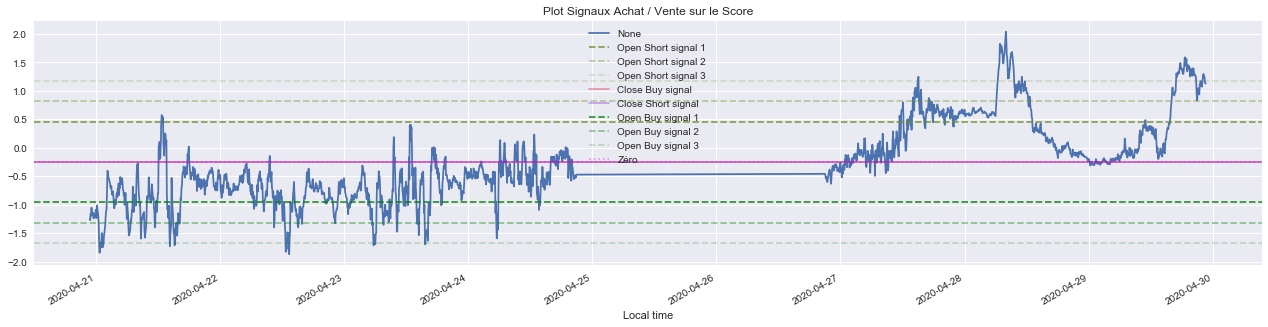

Dynamic NET PNL ( INIT ):  -1384.94 €
Heure Locale : 2020-04-30 00:43:07
Entrée dans la boucle...

Dynamic NET PNL ( INIT ):  -1394.47 €
Dynamic NET PNL ( INIT ):  -1404.35 €
Dynamic NET PNL ( INIT ):  -1408.34 €
Dynamic NET PNL ( INIT ):  -1410.41 €
Dynamic NET PNL ( INIT ):  -1411.69 €
Heure Locale : 2020-04-30 00:45:43
CALCUL DU DYNAMIC SCORE
   C A L C U L    D E    D Y N _ S  

Dernière convergence atteinte le  2020-04-16 18:00:00 



TAILLES DES POSITIONS :
EUR/USD :  120.0
AUD/USD :  8.776692200645774
CHF/USD :  151.31502813399172
GBP/USD :  -5.629321559447133
JPY/USD :  1395.9929877613622


Le Score max est :  3.012472300611728  et le Score min :  -2.760577247810526
 
Indice :  -1 2020-04-29 22:45:00
(Heure correspondanr à la dernière bougie récupérée)
 
   A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S  

L'amplitude détectée est de  3.9074999999999998
Limite short 1 0.45958359473174515 Limite short 2 0.8147403344624786 Limite short 3 1.16989707419

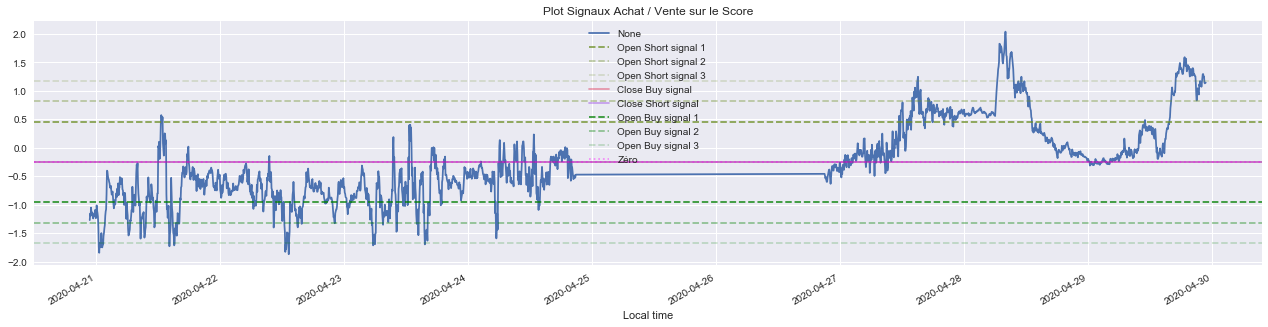



EXECUTION DU PROTOCOLE STAT-ARB



  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 

 NONE ===> ITERATION SUIVANTE


Travaux effectués. Retour à la veille jusqu'à la prochaine fenêtre
Dynamic NET PNL ( INIT ):  -1428.8 €
Dynamic NET PNL ( INIT ):  -1429.3 €
Heure Locale : 2020-04-30 00:46:01

In [10]:
#%%time
################################################
### BOUCLE DE CONTROLE ET PASSAGE DES ORDRES ###
################################################

if sell1 == 1 or sell2 == 1 or sell3 == 1:
    sens = 'SHORT'
if buy1 == 1 or buy2 == 1 or buy3 == 1:
    sens = 'LONG'

print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)
dyns_close()

timer = con.get_candles('AUD/USD',period=period,number=1)
if timer.index[-1].minute == dt.datetime.now().minute:
    print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)
    dyns()
    print('\n\n'+Fore.BLUE+'EXECUTION DU PROTOCOLE STAT-ARB'+Style.RESET_ALL)
    shoot()
    print("\nTravaux effectués. Retour à la veille jusqu'à la prochaine fenêtre")
    try:
        dyn_net_pnl = con.get_summary().netPL.sum()
    except:
        dyn_net_pnl = 0
    if dyn_net_pnl >0:
        print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')            
    elif dyn_net_pnl <0:
        print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')

    while timer.index[-1].minute == dt.datetime.now().minute:
        
        print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+Style.RESET_ALL,end='',flush=True)
        time.sleep(1)
    
else:
    try:
        dyn_net_pnl = con.get_summary().netPL.sum()
    except:
        dyn_net_pnl = 9999999999
        print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
    if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
        print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')
    elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
        print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')
    
    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+Style.RESET_ALL,end='',flush=True)
    time.sleep(30)
    print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+Style.RESET_ALL,end='',flush=True)

    print('\nEntrée dans la boucle...\n')

for loop in range(0,72000000):
    
    if sell1 == 1 or sell2 == 1 or sell3 == 1:
        sens = 'SHORT'
    if buy1 == 1 or buy2 == 1 or buy3 == 1:
        sens = 'LONG'

    timer = con.get_candles('AUD/USD',period=period,number=1)
    if timer.index[-1].minute == dt.datetime.now().minute:
        print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)
        dyns()
        print('\n\n'+Fore.BLUE+'EXECUTION DU PROTOCOLE STAT-ARB'+Style.RESET_ALL)
        shoot()
        print("\nTravaux effectués. Retour à la veille jusqu'à la prochaine fenêtre")
        try:
            dyn_net_pnl = con.get_summary().netPL.sum()
        except:
            dyn_net_pnl = 0
            print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
        if dyn_net_pnl >0:
            print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')            
        elif dyn_net_pnl <0:
            print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')
        while timer.index[-1].minute == dt.datetime.now().minute:
            print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+Style.RESET_ALL,end='',flush=True)
            time.sleep(1)
            
    else:
        try:
            dyn_net_pnl = con.get_summary().netPL.sum()
        except:
            dyn_net_pnl = 9999999999
            print('\r'+Fore.GREEN+'Dynamic NET PNL : Pas de positions ouvertes \n'+Style.RESET_ALL,end='')
        if dyn_net_pnl >=0 and dyn_net_pnl != 9999999999:
            print('\r'+Fore.GREEN+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')
        elif (dyn_net_pnl < 0) and (dyn_net_pnl != 9999999999) :
            print('\r'+Fore.RED+'Dynamic NET PNL (',sens,'): ',round(dyn_net_pnl,2),'€\n'+Style.RESET_ALL,end='')

        print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+Style.RESET_ALL,end='',flush=True)
        time.sleep(30)
        print('\r'+Fore.BLUE+'Heure Locale : '+str(dt.datetime.now())[:19]+Style.RESET_ALL,end='',flush=True)

            
       